In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator,WeightedAdder, LinearAmplitudeFunction

from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler

from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

In [19]:
n_z = 5
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25, 0.5, 0.12, 0.32]
rhos = [0.1, 0.05, 0.08, 0.03, 0.08]
lgd = [1, 2, 3, 1, 2]
K = len(p_zeros)
alpha = 0.05

In [4]:
u = GCI(n_z, z_max, p_zeros, rhos)

In [14]:
u_measure = u.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(u_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [20]:
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits

for i, prob in binary_probabilities.items():
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if i[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]
    
values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

In [21]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                2.9717
Value at Risk VaR[L]:              7.0000
P[L <= VaR[L]]:                    0.9854
Conditional Value at Risk CVaR[L]: 8.0000


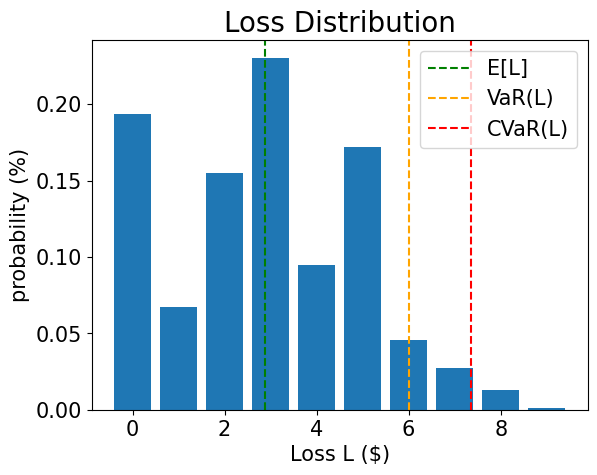

In [196]:
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

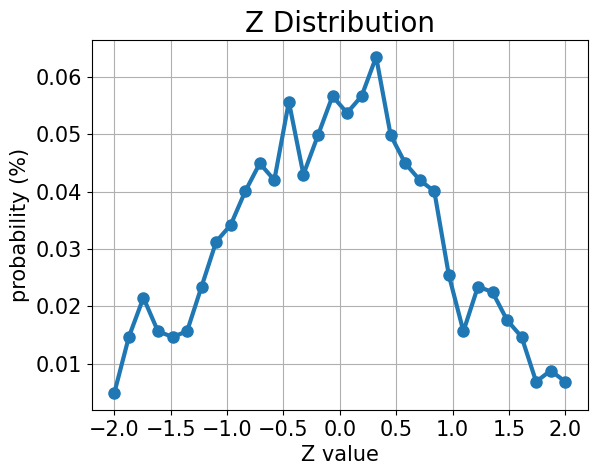

In [28]:
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

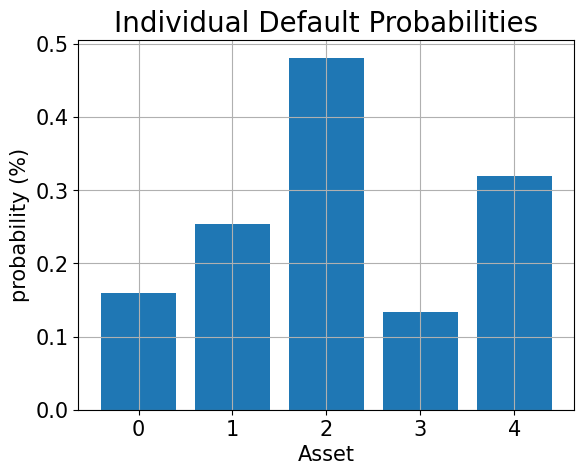

In [198]:
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

In [199]:
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

In [200]:
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [201]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_control = QuantumRegister(1, "control")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_control ,name="A")

state_preparation.draw()

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

# # linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# # uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

In [202]:
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
  state_0: ┤0      ├┤0        ├──────┤0           ├
           │       ││         │      │            │
  state_1: ┤1      ├┤1        ├──────┤1           ├
           │       ││         │      │            │
  state_2: ┤2      ├┤2        ├──────┤2           ├
           │       ││         │      │            │
  state_3: ┤3      ├┤3        ├──────┤3           ├
           │       ││         │      │            │
  state_4: ┤4      ├┤4        ├──────┤4           ├
           │  P(X) ││         │      │            │
  state_5: ┤5      ├┤5        ├──────┤5           ├
           │       ││         │      │            │
  state_6: ┤6      ├┤6        ├──────┤6           ├
           │       ││         │      │            │
  state_7: ┤7      ├┤7        ├──────┤7           ├
           │       ││         │      │            │
  state_8: ┤8      ├┤8        ├──────┤8           ├
           │       ││         │      │            │
  state_9: ┤9      ├┤9  adder ├──────┤9  adder_dg ├
           └───────┘│         │┌────┐│            │
objective: ─────────┤         ├┤4   ├┤            ├
                    │         ││    ││            │
    sum_0: ─────────┤10       ├┤0   ├┤10          ├
                    │         ││    ││            │
    sum_1: ─────────┤11       ├┤1 F ├┤11          ├
                    │         ││    ││            │
    sum_2: ─────────┤12       ├┤2   ├┤12          ├
                    │         ││    ││            │
    sum_3: ─────────┤13       ├┤3   ├┤13          ├
                    │         │└────┘│            │
  carry_0: ─────────┤14       ├──────┤14          ├
                    │         │      │            │
  carry_1: ─────────┤15       ├──────┤15          ├
                    │         │      │            │
  carry_2: ─────────┤16       ├──────┤16          ├
                    │         │      │            │
  control: ─────────┤17       ├──────┤17          ├
                    └─────────┘      └────────────┘

In [203]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [204]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   2.8848
Exact Operator Value:  0.4199
Mapped Operator value: 2.6647


In [205]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	2.8848
Estimated value:	2.9106
Confidence interval: 	[2.7741, 3.0471]


In [206]:
x_eval = 3

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)


In [207]:
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │      │
state_3: ┤3     ├
         │  cmp │
compare: ┤4     ├
         │      │
 a298_0: ┤5     ├
         │      │
 a298_1: ┤6     ├
         │      │
 a298_2: ┤7     ├
         └──────┘

In [208]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")
    qr_control = QuantumRegister(1, "control")

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry,qr_control, name="A")

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

    return state_preparation

In [209]:
state_preparation = get_cdf_circuit(x_eval)


In [210]:
state_preparation.draw()

┌───────┐┌─────────┐        ┌────────────┐
  state_0: ┤0      ├┤0        ├────────┤0           ├
           │       ││         │        │            │
  state_1: ┤1      ├┤1        ├────────┤1           ├
           │       ││         │        │            │
  state_2: ┤2      ├┤2        ├────────┤2           ├
           │       ││         │        │            │
  state_3: ┤3      ├┤3        ├────────┤3           ├
           │       ││         │        │            │
  state_4: ┤4      ├┤4        ├────────┤4           ├
           │  P(X) ││         │        │            │
  state_5: ┤5      ├┤5        ├────────┤5           ├
           │       ││         │        │            │
  state_6: ┤6      ├┤6        ├────────┤6           ├
           │       ││         │        │            │
  state_7: ┤7      ├┤7        ├────────┤7           ├
           │       ││         │        │            │
  state_8: ┤8      ├┤8        ├────────┤8           ├
           │       ││         │        │            │
  state_9: ┤9      ├┤9  adder ├────────┤9  adder_dg ├
           └───────┘│         │┌──────┐│            │
objective: ─────────┤         ├┤4     ├┤            ├
                    │         ││      ││            │
    sum_0: ─────────┤10       ├┤0     ├┤10          ├
                    │         ││      ││            │
    sum_1: ─────────┤11       ├┤1     ├┤11          ├
                    │         ││      ││            │
    sum_2: ─────────┤12       ├┤2     ├┤12          ├
                    │         ││  cmp ││            │
    sum_3: ─────────┤13       ├┤3     ├┤13          ├
                    │         ││      ││            │
  carry_0: ─────────┤14       ├┤5     ├┤14          ├
                    │         ││      ││            │
  carry_1: ─────────┤15       ├┤6     ├┤15          ├
                    │         ││      ││            │
  carry_2: ─────────┤16       ├┤7     ├┤16          ├
                    │         │└──────┘│            │
  control: ─────────┤17       ├────────┤17          ├
                    └─────────┘        └────────────┘

In [211]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [212]:
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(3) = 0.6309
Exact    CDF(3) = 0.6465


In [213]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.6465
Estimated value:	0.6465
Confidence interval: 	[0.6434, 0.6496]


In [214]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
    )
    result_var = ae_var.estimate(problem)

    return result_var.estimation

In [215]:
def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [216]:
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         4       0.736     9            1.000
 4           0.736         6       0.949     9            1.000
 6           0.949         8       0.999     9            1.000
 6           0.949         7       0.986     8            0.999
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [217]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

Estimated Value at Risk:  7
Exact Value at Risk:      6
Estimated Probability:    0.986
Exact Probability:        0.959


In [218]:
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [219]:
cvar_objective.draw()

┌────┐
q1494_0: ┤0   ├
         │    │
q1494_1: ┤1   ├
         │    │
q1494_2: ┤2   ├
         │    │
q1494_3: ┤3   ├
         │    │
  q1495: ┤4 F ├
         │    │
 a412_0: ┤5   ├
         │    │
 a412_1: ┤6   ├
         │    │
 a412_2: ┤7   ├
         │    │
 a412_3: ┤8   ├
         └────┘

In [220]:
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")
qr_control = QuantumRegister(1, "control")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, qr_control, name="A")

# load the random variable
state_preparation.append(u, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

In [221]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [222]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

Estimated CVaR: -4.8409
Exact CVaR:     7.3571


In [223]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result_cvar = ae_cvar.estimate(problem)

In [224]:
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))

Exact CVaR:    	7.3571
Estimated CVaR:	4.7341
